<span style='color:red'> NOTE: You can only pass the lab, when you provide both code and markdown </span>

Use Code for your analysis
Use Markdown to document and elaborate on your findings, conclusions, assertions, etc.

# DS_ML_I_P3: Visualizing a large Dataset and Checking for Simpsons Paradox
Below you will find a large(r) dataset with time series data of environmental sensors


Hint: Rooms with a '0' as second digit have a different orientation than rooms with a '1'

You might use you own dataset as well under the asumption:
* you have time series data
* you have at least three additional features that depend on time


In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import plotly.express as px
import plotly.graph_objects as go

## 1 Load the data into a dataframe and convert the date strings

Hint, you might also find a parquet file. In that case, you can use the parquet file. It has the date already converted.

In [278]:
%time df = pd.read_parquet("07092021bimsim_room.parquet")

CPU times: total: 2.38 s
Wall time: 1.5 s


## 2 Remove duplicate or unused data to reduce total memory consumption

Domain knowledge:
* the columns "source" and "sensor" are identical
* "sensor" and "room" have a 1:1 mapping
* "id" contains the datetime as float
* some sensors might deliver negative temperatures <100°C. This is an errorneous measurement

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625329 entries, 0 to 1625328
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   source    1625329 non-null  object 
 1   datetime  1625329 non-null  object 
 2   id        1625329 non-null  float64
 3   celsius   1625329 non-null  float64
 4   pressure  1625329 non-null  float64
 5   humidity  1625329 non-null  float64
 6   sensor    1625329 non-null  object 
 7   room      1619653 non-null  object 
dtypes: float64(4), object(4)
memory usage: 99.2+ MB


### Confirming check whether source & sensor are equal

In [280]:
# your code here
print(f"Source column = sensor column --> {df['source'].equals(df['sensor'])}")

Source column = sensor column --> True


Since the "source" and "sensor" are identical, drop "source"

In [281]:
df.drop(columns=['source'], inplace=True)

### Check to confirm the 1:1 mapping of "sensor" and "room"

Almost every sensor is linked to just one room, but some sensors don’t have a room assigned yet. So, the idea that each sensor matches exactly one room mostly holds true, though some room info is missing. Because of this, we could drop the room column to avoid repetition, but I’m keeping it for now since the room details might be useful later

In [282]:
df[['sensor','room']].drop_duplicates().sort_values('room')

,sensor,room
234509,0013A20041A94C19,H106
1568428,0013A20041A951B1,H108
820975,0013A20041A94C62,H109
36562,0013A20041A94C04,H110
1214469,0013A20041A94CA6,H111
470533,0013A20041A94FA5,H113
938833,0013A20041A94FBB,H116
0,0013A20041A94BE7,H203
274389,0013A20041A94FA3,H205
671665,0013A20041A94FB9,H206


Count how many rows have missing room values

In [283]:
missing_room = df['room'].isna()
print(f"rows with missing room value: {len(df[missing_room])}")
print(f"total rows: {len(df)}")
print(f"percentage: {round(len(df[missing_room])/len(df)*100, 2)}")


rows with missing room value: 5676
total rows: 1625329
percentage: 0.35


Because of the 1:1 mapping, those rows can be removed, as we cannot determine which specific rooms in the building the sensors belong to anyway

In [284]:
df.dropna(subset=['room'],inplace=True)
len(df)

1619653

### Handling the "id" and "datetime"

convert id and datetime into pandas datetime for the sake of comparison, after checking the datatype of each respective columns 

In [285]:
print(df['datetime'].dtype)
print(df['id'].dtype)

object
float64


In [286]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('s')
df['id'] = pd.to_datetime(df['id'], unit='s').dt.floor('s')
df['datetime_equals_id'] = (df['datetime'] == df['id'])
df['time_difference'] = df['datetime'] - df['id']

By examining the dataframe below, it’s clear that the "datetime" and "id" columns are not equal. There is a 1- to 2-hour time difference between them. This could be because the "id" column uses naive (timezone-unaware) timestamps, while "datetime" appears to be recorded in a timezone that observes daylight saving time—possibly Germany, given the time shifts between winter and summer.

In [287]:
df[['datetime','id', 'datetime_equals_id']]

,datetime,id,datetime_equals_id
0,2021-03-21 01:46:22,2021-03-21 00:46:22,False
1,2021-03-21 01:51:24,2021-03-21 00:51:24,False
2,2021-03-21 01:56:27,2021-03-21 00:56:27,False
3,2021-03-21 02:01:29,2021-03-21 01:01:29,False
4,2021-03-21 02:06:31,2021-03-21 01:06:31,False
...,...,...,...
1625324,2021-09-07 01:34:47,2021-09-06 23:34:47,False
1625325,2021-09-07 01:39:51,2021-09-06 23:39:51,False
1625326,2021-09-07 01:44:55,2021-09-06 23:44:55,False
1625327,2021-09-07 01:49:59,2021-09-06 23:49:59,False


In [288]:
df['time_difference'].unique()

<TimedeltaArray>
['0 days 01:00:00', '0 days 02:00:00', '0 days 00:59:59', '0 days 01:59:59']
Length: 4, dtype: timedelta64[ns]

However, in my opinion, one timestamp column is enough despite the difference; therefore, the "id" column can be dropped without any big worry and the "datetime" column can be kept. 

Some other columns created for the check before will also be dropped.

In [289]:
df.drop(columns=['id', 'datetime_equals_id', 'time_difference'], inplace=True)

### Handling the "sensor"

It is shown below that the rows with error measurement are only a small minority 

In [290]:
rows_with_error_temperature = df[df['celsius']<-100].shape[0]
total_rows = df.shape[0]

print(f"{rows_with_error_temperature} rows out of {total_rows} have errornous measurement.")
print(f"{round(rows_with_error_temperature/total_rows*100, 3)} % of the total data")


687 rows out of 1619653 have errornous measurement.
0.042 % of the total data


Since we work with timeseries data, the rows with temperature can't be removed just like that. Therefore, those values will be subtituted with NaN for now

In [291]:
df.loc[df['celsius']<-100, 'celsius'] = pd.NA

Plotting the celsius values over time to see how the time gap look like

In [ ]:
# import matplotlib.pyplot as plt

# # Filter only rows with valid sensor (but keep NaN in celsius)
# df_valid_sensor = df[df['sensor'].notna()]

# # Group by sensor
# for sensor, group in df_valid_sensor.groupby('sensor'):
#     group = group.sort_values('datetime')

#     plt.figure(figsize=(9, 2))
#     # Plot including NaNs in 'celsius' - the line will break at NaNs automatically
#     # plt.scatter(group['datetime'], group['celsius'], marker='.', label=f'sensor {sensor}', linestyle=None)
#     plt.scatter(group['datetime'], group['celsius'], marker='.', linestyle='None', label=f'sensor {sensor}')

#     plt.title(f'Celsius Over Time - sensor {sensor}')
#     plt.xlabel('Time')
#     plt.ylabel('Temperature (°C)')
#     plt.tight_layout()
#     plt.grid(True)
#     plt.legend()
#     plt.show()


Since the gaps are random as seen in the charts above, the it would make more sense to just drop the rows with faulty temperature measurement, instead of doing some kind of imputation. Moreover, they are only a small minority of the dataset

In [293]:
df.dropna(subset=['celsius'],inplace=True)

## 3 Visualize the data 

Perform Visualizations for different types of diagrams using either

1. matpolotlib/seaborn
2. plotly

**Important Hint**: Check the total volume of data points first. If needed create a digestible subset. Keep in mind, that visualizing large volumes of data points (i.e. > 10e5) can significantly slow down the notebook. Too many datapoints might even crash the browser, due to limited RAM availability for a browser tab in all common browsers.

## 3.0 Create different table aggregations to check for "Simposons Paradox"
Hints: 
* Find an appropriate aggregation of which you think, it could generate a paradox. E.g. compare an aggregation of multiple rooms with a single rooom.
* Rooms with a '0' in the middle are on one side of the building, with a '1' on another.
* There are also errorneous values in the data, that you might want to remove first.
* Consider different time spans. During the winter period, many rooms a heated. During summer, the room temperatures are more influenced by the outside environmental conditions

Add two columns: one for the building side based on the room number, and one for the season when the measurement was taken.

In [294]:
import re

def extract_side(room):
    # Search for 'H' followed by 3 digits and get the middle digit
    match = re.match(r'H(\d)(\d)(\d)', room)
    if match:
        return match.group(2)
    else:
        match = re.search(r'H(\d)(\d)', room)
        if match:
            return match.group(2)
        else:
            return None  # or some default value

df['side'] = df['room'].apply(extract_side)

def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function the pandas way
df['season'] = df['datetime'].apply(get_season)


The first instance of Simpson's Paradox appears when comparing the correlation between Celsius (temperature) and humidity. When analyzing the entire dataset, the correlation is slightly positive. However, when the data is grouped by season, each individual season shows a negative correlation.

In [319]:
print(f"The correlation value between Celsius and Humidity on the whole dataset:\n {df['celsius'].corr(df['humidity']).round(3)}")

The correlation value between Celsius and Humidity on the whole dataset:
 0.177


In [ ]:
corr_per_season = df.groupby('season')[['celsius', 'humidity']].apply(
    lambda x: x['celsius'].corr(x['humidity']).round(3)
)
print("Correlation between Celsius and Humidity based on season:\n", corr_per_season)

Correlation between Celsius and Humidity based on season:
 season
Autumn   -0.024
Spring   -0.499
Summer   -0.720
Winter   -0.495
dtype: float64


We can also see when it is grouped by room, two rooms actually have negative correlation for celsius and humidity

In [334]:
corr_per_season = df.groupby('room')[['celsius', 'humidity']].apply(
    lambda x: x['celsius'].corr(x['humidity']).round(3)
)
print("Correlation between Celsius and Humidity based on season:\n", corr_per_season)

Correlation between Celsius and Humidity based on season:
 room
H106                           0.478
H108                           0.303
H109                           0.620
H110                           0.658
H111                           0.399
H113                           0.582
H116                           0.536
H203                           0.327
H205                           0.001
H206                           0.145
H207                           0.447
H208                           0.466
H209                          -0.111
H210                          -0.056
H211                           0.138
H212                           0.321
H213                           0.150
H214                           0.292
H215                           0.068
H216                           0.313
H216_desk_at_window            0.211
H217                           0.109
H218                           0.566
H220                           0.431
across_from_H207_on_railing    0.042
dtype: floa

## 3.1 Create a graph over time
Use the line or scatter graphs to check for simpsons paradox.
What is the difference in the perception of the data when using line graphs compared to scatter graphs? Think about missing data!

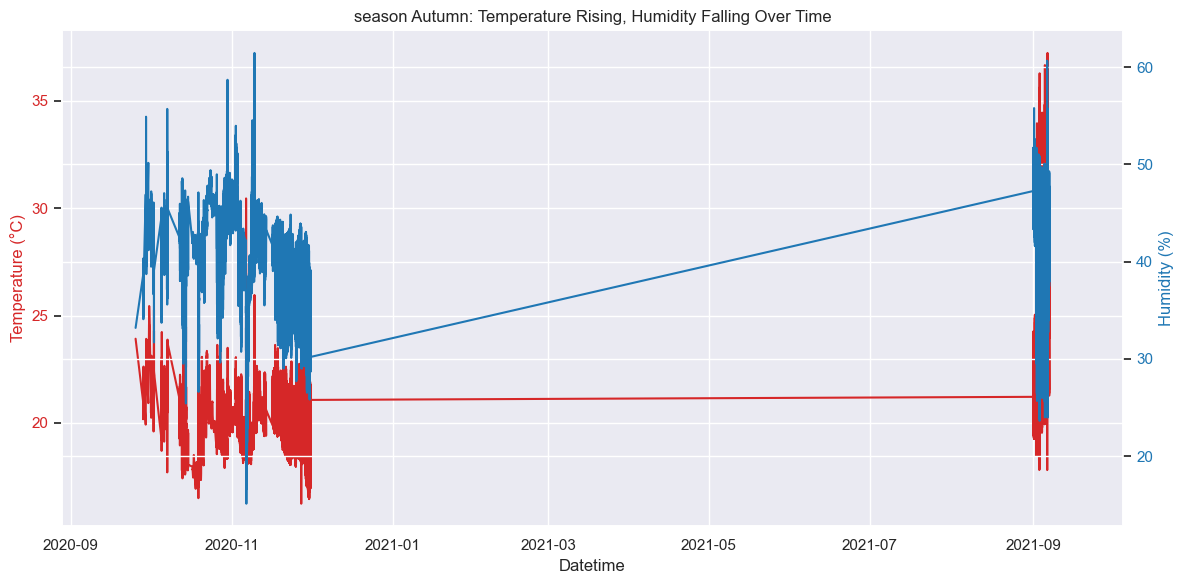

In [ ]:
import matplotlib.pyplot as plt

# Filter and sort data for season Autumn
df_Autumn = df[df['season'] == 'Autumn'].sort_values('datetime')

# Get min and max datetime
x_min = df_Autumn['datetime'].min() - pd.Timedelta(days=28)
x_max = df_Autumn['datetime'].max() + pd.Timedelta(days=28)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on left y-axis
color1 = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Temperature (°C)', color=color1)
ax1.scatter(df_Autumn['datetime'], df_Autumn['celsius'], color=color1, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color1)

# Set x-axis range
ax1.set_xlim([x_min, x_max])

# Create second y-axis for humidity
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Humidity (%)', color=color2)
ax2.scatter(df_Autumn['datetime'], df_Autumn['humidity'], color=color2, label='Humidity')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('season Autumn: Temperature Rising, Humidity Falling Over Time')
fig.tight_layout()
plt.show()


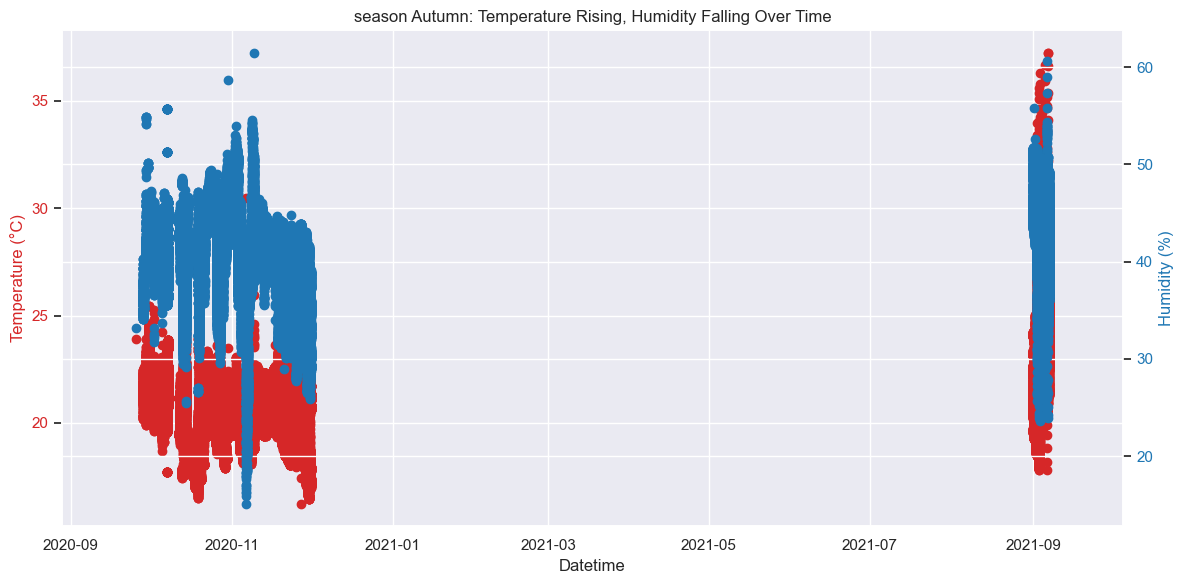

In [355]:
import matplotlib.pyplot as plt

# Filter and sort data for season Autumn
df_Autumn = df[df['season'] == 'Autumn'].sort_values('datetime')

# Get min and max datetime
x_min = df_Autumn['datetime'].min() - pd.Timedelta(days=28)
x_max = df_Autumn['datetime'].max() + pd.Timedelta(days=28)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on left y-axis
color1 = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Temperature (°C)', color=color1)
ax1.scatter(df_Autumn['datetime'], df_Autumn['celsius'], color=color1, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color1)

# Set x-axis range
ax1.set_xlim([x_min, x_max])

# Create second y-axis for humidity
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Humidity (%)', color=color2)
ax2.scatter(df_Autumn['datetime'], df_Autumn['humidity'], color=color2, label='Humidity')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('season Autumn: Temperature Rising, Humidity Falling Over Time')
fig.tight_layout()
plt.show()


## 3.2 Create a 2D and 3D scatterplot for the environmental data

Create a new smaller subset of data for the sake of power in showing the scatterplot

In [ ]:
df_subset_of_room_6s = df[df['room'].isin(['H106', 'H116'])]

Show 2D Scatterplot

In [330]:
fig_2d = px.scatter(
    df_subset_of_room_6s,
    x='celsius',
    y='humidity',
    color='season',
    title='2D Scatterplot: Celsius vs Humidity by Season',
    labels={'celsius': 'Temperature (°C)', 'humidity': 'Humidity (%)'},
    height=500
)

fig_2d.show()

Show 3D Scatter Plot

In [ ]:
# your code here

fig_3d = px.scatter_3d(
    df_subset_of_room_6s,
    x='celsius',
    y='pressure',
    z='humidity',
    color='season',
    title='3D Scatterplot: Celsius, Humidity, and Pressure by Season',
    labels={
        'celsius': 'Temperature (°C)',
        'pressure': 'Pressure (hPa)',
        'humidity': 'Humidity (%)',
    },
    height=500
)

fig_3d.show()